# Partie 7 : DIFFERENT KINDS OF MODEL CAPACITY

## Test code RBF simple

For example shallow RBF networks with
    p(y = 1 | x)=exp((x -mu)^(T) Beta(x-mu))
are only able to confidently predict that the positive class is present in the vicinity of mu. Elsewhere, they default to predicting the class is absent, or have low-confidence predictions.
RBF networks are naturally immune to adversarial examples, in the sense that they have low confidence when they are fooled. A shallow RBF network with no hidden layers gets an error rate of 55.4% on MNIST using adversarial examples generated with the fast gradient sign method and epsilon = 25. However, its confidence on mistaken examples is only 12%. Its average confidence on clean test examples is 606%. We can’t expect a model with such low capacity to get the right answer at all points of space, but it does correctly respond by reducing its confidence considerably on points it does not “understand.”

Epoch [1/20], Loss: 2.3025851249694824
Epoch [2/20], Loss: 2.3025851249694824
Epoch [3/20], Loss: 2.3025851249694824
Epoch [4/20], Loss: 2.3025851249694824
Epoch [5/20], Loss: 2.3025851249694824
Epoch [6/20], Loss: 2.3025851249694824
Epoch [7/20], Loss: 2.3025851249694824
Epoch [8/20], Loss: 2.3025851249694824
Epoch [9/20], Loss: 2.3025851249694824
Epoch [10/20], Loss: 2.3025851249694824
Epoch [11/20], Loss: 2.3025851249694824
Epoch [12/20], Loss: 2.3025851249694824
Epoch [13/20], Loss: 2.3025851249694824
Epoch [14/20], Loss: 2.3025851249694824
Epoch [15/20], Loss: 2.3025851249694824
Epoch [16/20], Loss: 2.3025851249694824
Epoch [17/20], Loss: 2.3025851249694824
Epoch [18/20], Loss: 2.3025851249694824
Epoch [19/20], Loss: 2.3025851249694824
Epoch [20/20], Loss: 2.3025851249694824
Accuracy on adversarial examples: 9.871666666666666%


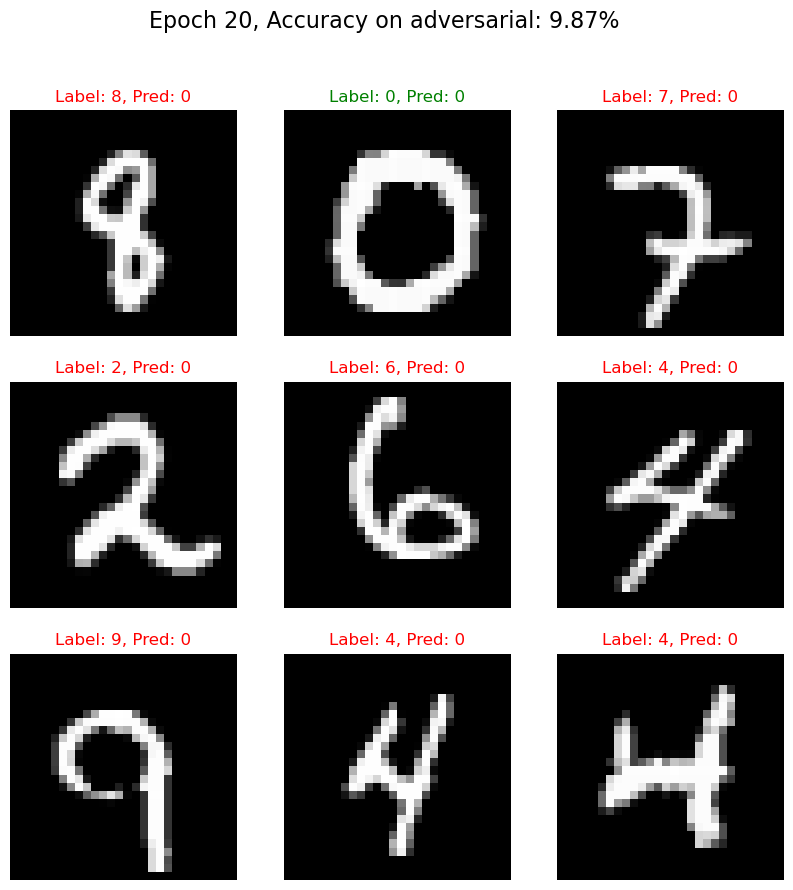

In [3]:
# @title Version 1, RBF network simple avec epsilon = 0.25
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Subset
from torch.autograd import Variable

# Définition de l'attaque FGSM
def FGSM(model, images, labels, epsilon):
    images.requires_grad = True

    outputs = model(images)
    labels = labels.to(outputs.device)
    loss = nn.CrossEntropyLoss()(outputs, labels)

    model.zero_grad()
    loss.backward()

    # Génération des perturbations adversariales
    perturbation = epsilon * images.grad.sign()
    adversarial_images = images + perturbation
    adversarial_images = torch.clamp(adversarial_images, 0, 1)

    return adversarial_images

# Classe du réseau RBF
class RBFNetwork(nn.Module):
    def __init__(self, num_centers, input_dim, num_classes, beta=1.0):
        super(RBFNetwork, self).__init__()
        self.num_centers = num_centers
        self.beta = beta
        self.centers = nn.Parameter(torch.randn(num_centers, input_dim))
        self.weights = nn.Linear(num_centers, num_classes, bias=False)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Aplatir les images
        distances = torch.cdist(x, self.centers)  # Distance euclidienne
        rbf_activations = torch.exp(-self.beta * distances**2)
        return self.weights(rbf_activations)

# Charger les données MNIST
def load_data():
    transform = transforms.Compose([transforms.ToTensor()])
    full_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(full_dataset, batch_size=64, shuffle=True)
    return train_loader

# Entraînement sur des données normales
def train_on_normal_data(model, train_loader, optimizer, epochs=10):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(torch.float32), labels

            optimizer.zero_grad()
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}")

# Test sur des données adversariales
def test_on_adversarial_data(model, train_loader, epsilon):
    model.eval()
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(torch.float32), labels
        adversarial_images = FGSM(model, images, labels, epsilon)
        outputs = model(adversarial_images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on adversarial examples: {accuracy}%')
    return accuracy

# Fonction pour afficher les images
def plot_images(images, labels, predictions, accuracy, epoch):
    plt.figure(figsize=(10, 10))

    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].detach().cpu().numpy().squeeze(), cmap='gray')
        label = labels[i].item()
        pred = predictions[i].item()

        color = 'g' if label == pred else 'r'
        plt.title(f"Label: {label}, Pred: {pred}", color=color)
        plt.axis('off')

    plt.suptitle(f"Epoch {epoch}, Accuracy on adversarial: {accuracy:.2f}%", fontsize=16)
    plt.show()

# Fonction principale
def main():
    # Paramètres
    epsilon = 0.25
    epochs = 20

    # Charger les données
    train_loader = load_data()

    # Initialiser le modèle RBF
    input_dim = 28 * 28
    num_classes = 10
    num_centers = 100
    model = RBFNetwork(num_centers, input_dim, num_classes, beta=0.5)

    # Optimiseur
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Entraîner sur des données normales
    train_on_normal_data(model, train_loader, optimizer, epochs)

    # Tester sur des données adversariales
    accuracy = test_on_adversarial_data(model, train_loader, epsilon)

    # Afficher quelques exemples adversariaux
    data_iter = iter(train_loader)
    images, labels = next(data_iter)
    adversarial_images = FGSM(model, images, labels, epsilon)

    outputs = model(adversarial_images)
    _, predictions = torch.max(outputs, 1)

    plot_images(adversarial_images, labels, predictions, accuracy, epochs)

# Exécuter la fonction principale
if __name__ == "__main__":
    main()


Epoch [1/20], Loss: 2.277432460774745
Epoch [2/20], Loss: 2.2426875819529553
Epoch [3/20], Loss: 2.2213306035568463
Epoch [4/20], Loss: 2.205311183355002
Epoch [5/20], Loss: 2.192585401062264
Epoch [6/20], Loss: 2.1821673268448314
Epoch [7/20], Loss: 2.172592959932681
Epoch [8/20], Loss: 2.1637102371848216
Epoch [9/20], Loss: 2.1567003565556457
Epoch [10/20], Loss: 2.150080563671299
Epoch [11/20], Loss: 2.1439811249277483
Epoch [12/20], Loss: 2.137903905245287
Epoch [13/20], Loss: 2.1327067924969234
Epoch [14/20], Loss: 2.12738632711012
Epoch [15/20], Loss: 2.12278251060799
Epoch [16/20], Loss: 2.118461595796573
Epoch [17/20], Loss: 2.114350625828131
Epoch [18/20], Loss: 2.110705640524435
Epoch [19/20], Loss: 2.10649577285181
Epoch [20/20], Loss: 2.1036412197389582
Accuracy on adversarial examples: 10.441666666666666%


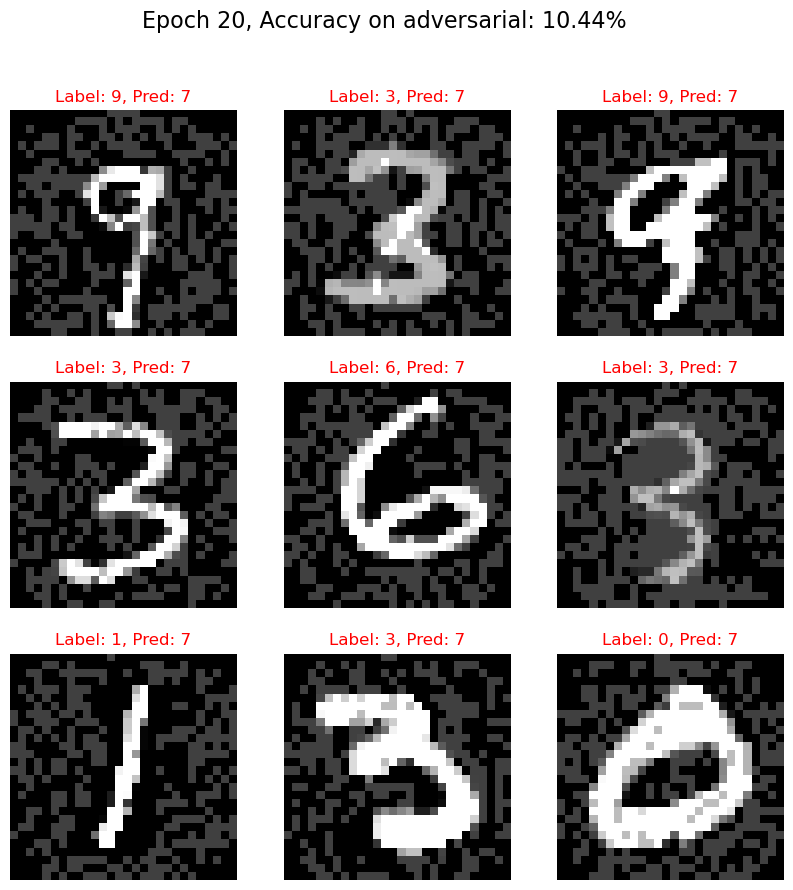

In [ ]:
# @title Version 2, RBF network simple avec epsilon = 0.25
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.autograd import Variable

# Définition de l'attaque FGSM
def FGSM(model, images, labels, epsilon):
    images.requires_grad = True

    outputs = model(images)
    labels = labels.to(outputs.device)
    loss = nn.CrossEntropyLoss()(outputs, labels)

    model.zero_grad()
    loss.backward()

    # Génération des perturbations adversariales
    perturbation = epsilon * images.grad.sign()
    adversarial_images = images + perturbation
    adversarial_images = torch.clamp(adversarial_images, 0, 1)

    return adversarial_images

# Classe du réseau RBF
class RBFNetworkNoHidden(nn.Module):
    def __init__(self, num_centers, input_dim, num_classes, beta=1.0):
        super(RBFNetworkNoHidden, self).__init__()
        self.num_centers = num_centers
        self.beta = beta
        self.centers = nn.Parameter(torch.randn(num_centers, input_dim))  # Centres RBF
        self.weights = nn.Linear(num_centers, num_classes, bias=True)    # Ajout du biais

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Aplatir les images
        distances = torch.cdist(x, self.centers)  # Distance euclidienne
        rbf_activations = torch.exp(-self.beta * distances**2)  # Activation RBF
        return self.weights(rbf_activations)

# Ajuster les centres avec les données d'entraînement
def initialize_centers_with_kmeans(train_loader, num_centers, input_dim):
    from sklearn.cluster import KMeans
    all_data = []
    for images, _ in train_loader:
        images = images.view(images.size(0), -1).numpy()
        all_data.append(images)
    all_data = np.vstack(all_data)
    kmeans = KMeans(n_clusters=num_centers).fit(all_data)
    return torch.tensor(kmeans.cluster_centers_, dtype=torch.float32)

# Charger les données MNIST
def load_data():
    transform = transforms.Compose([transforms.ToTensor()])
    full_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(full_dataset, batch_size=64, shuffle=True)
    return train_loader

# Entraînement sur des données normales
def train_on_normal_data(model, train_loader, optimizer, epochs=10):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(torch.float32), labels
            optimizer.zero_grad()
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader)}")

# Test sur des données adversariales
def test_on_adversarial_data(model, train_loader, epsilon):
    model.eval()
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(torch.float32), labels
        adversarial_images = FGSM(model, images, labels, epsilon)
        outputs = model(adversarial_images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on adversarial examples: {accuracy}%')
    return accuracy

# Fonction pour afficher les images
def plot_images(images, labels, predictions, accuracy, epoch):
    plt.figure(figsize=(10, 10))

    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].detach().cpu().numpy().squeeze(), cmap='gray')
        label = labels[i].item()
        pred = predictions[i].item()

        color = 'g' if label == pred else 'r'
        plt.title(f"Label: {label}, Pred: {pred}", color=color)
        plt.axis('off')

    plt.suptitle(f"Epoch {epoch}, Accuracy on adversarial: {accuracy:.2f}%", fontsize=16)
    plt.show()

# Fonction principale
def main():
    # Paramètres
    epsilon = 0.25
    epochs = 20

    # Charger les données
    train_loader = load_data()

    # Initialiser le modèle RBF
    input_dim = 28 * 28
    num_classes = 10
    num_centers = 100
    model = RBFNetworkNoHidden(num_centers, input_dim, num_classes, beta=0.5)
    # Initialiser les centres avec k-means
    model.centers.data = initialize_centers_with_kmeans(train_loader, num_centers, input_dim)

    # Optimiseur
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Entraîner sur des données normales
    train_on_normal_data(model, train_loader, optimizer, epochs)

    # Tester sur des données adversariales
    accuracy = test_on_adversarial_data(model, train_loader, epsilon)

    # Afficher quelques exemples adversariaux
    data_iter = iter(train_loader)
    images, labels = next(data_iter)
    adversarial_images = FGSM(model, images, labels, epsilon)

    outputs = model(adversarial_images)
    _, predictions = torch.max(outputs, 1)

    plot_images(adversarial_images, labels, predictions, accuracy, epochs)

# Exécuter la fonction principale
if __name__ == "__main__":
    main()


Epoch [1/30], Loss: 1.8429341045524013
Epoch [2/30], Loss: 1.63593952068642
Epoch [3/30], Loss: 1.5967341426338977
Epoch [4/30], Loss: 1.576756858876519
Epoch [5/30], Loss: 1.5637468452900967
Epoch [6/30], Loss: 1.5544807407647563
Epoch [7/30], Loss: 1.5472413166753773
Epoch [8/30], Loss: 1.5415378435334164
Epoch [9/30], Loss: 1.536869350399798
Epoch [10/30], Loss: 1.532912183799215
Epoch [11/30], Loss: 1.529578136991082
Epoch [12/30], Loss: 1.5265728558050289
Epoch [13/30], Loss: 1.5240127905599599
Epoch [14/30], Loss: 1.521677352345066
Epoch [15/30], Loss: 1.5196320697951164
Epoch [16/30], Loss: 1.5178150298244664
Epoch [17/30], Loss: 1.5161841431660439
Epoch [18/30], Loss: 1.5144754819778492
Epoch [19/30], Loss: 1.5130053953067073
Epoch [20/30], Loss: 1.5117420038180565
Epoch [21/30], Loss: 1.5104101040978422
Epoch [22/30], Loss: 1.5094005490925266
Epoch [23/30], Loss: 1.5082618467080822
Epoch [24/30], Loss: 1.5072826396173507
Epoch [25/30], Loss: 1.5063551026366666
Epoch [26/30], L

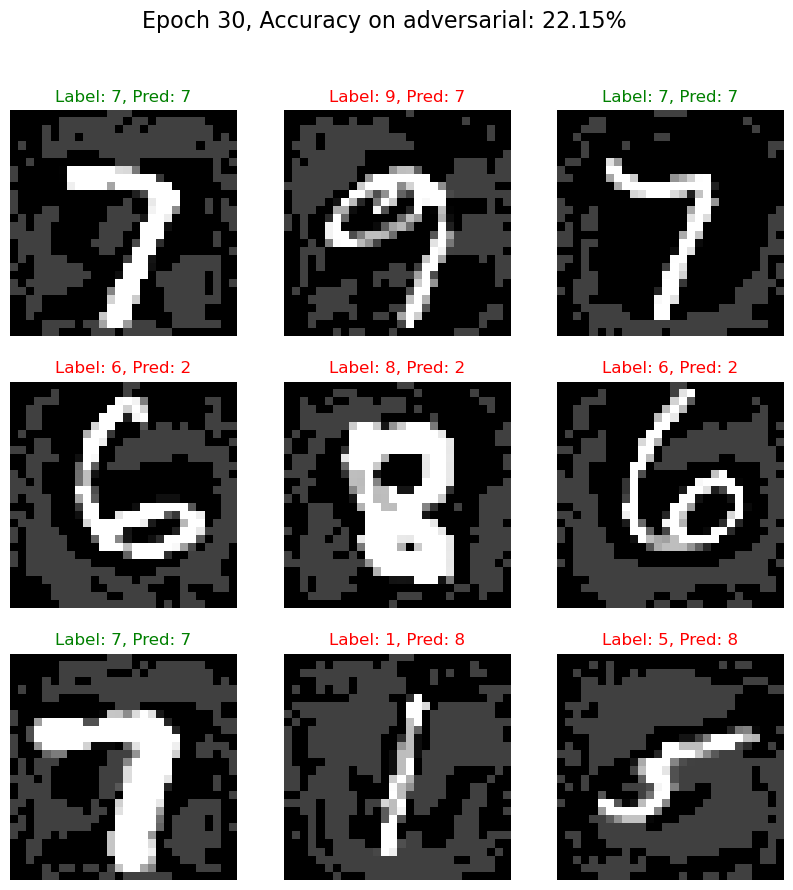

In [6]:
# @title Version 3, RBF network simple avec epsilon = 0.25

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.autograd import Variable



# Définition de l'attaque FGSM
def FGSM(model, images, labels, epsilon):
    images.requires_grad = True

    outputs = model(images)
    labels = labels.to(outputs.device)
    loss = nn.CrossEntropyLoss()(outputs, labels)

    model.zero_grad()
    loss.backward()

    # Génération des perturbations adversariales
    perturbation = epsilon * images.grad.sign()
    adversarial_images = images + perturbation
    adversarial_images = torch.clamp(adversarial_images, 0, 1)

    return adversarial_images
# Classe du réseau RBF
class RBFNetworkNoHidden(nn.Module):
    def __init__(self, num_centers, input_dim, num_classes, beta=1.0):
        super(RBFNetworkNoHidden, self).__init__()
        self.num_centers = num_centers
        self.beta = beta
        self.centers = nn.Parameter(torch.randn(num_centers, input_dim))  # Centres RBF
        self.weights = nn.Linear(num_centers, num_classes, bias=True)
        nn.init.xavier_uniform_(self.weights.weight)  # Initialisation équilibrée
        nn.init.zeros_(self.weights.bias)            # Initialisation du biais à zéro

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Aplatir les images
        distances = torch.cdist(x, self.centers)  # Distance euclidienne
        rbf_activations = torch.exp(-self.beta * distances**2)  # Activation RBF
        return torch.softmax(self.weights(rbf_activations), dim=1)  # Normalisation softmax

# Ajuster les centres avec les données d'entraînement
def initialize_centers_balanced_kmeans(train_loader, num_centers, num_classes, input_dim):
    from sklearn.cluster import KMeans
    all_data = {i: [] for i in range(num_classes)}  # Dictionnaire pour chaque classe

    for images, labels in train_loader:
        images = images.view(images.size(0), -1).numpy()
        for i, label in enumerate(labels):
            all_data[label.item()].append(images[i])

    centers = []
    centers_per_class = num_centers // num_classes
    for i in range(num_classes):
        if len(all_data[i]) > 0:
            class_data = np.vstack(all_data[i])
            kmeans = KMeans(n_clusters=centers_per_class).fit(class_data)
            centers.append(kmeans.cluster_centers_)

    return torch.tensor(np.vstack(centers), dtype=torch.float32)
# Test sur des données adversariales (avec affichage des confiances)
def test_on_adversarial_data(model, train_loader, epsilon):
    model.eval()
    correct = 0
    total = 0
    confidences_correct = []
    confidences_incorrect = []

    for images, labels in train_loader:
        images, labels = images.to(torch.float32), labels
        adversarial_images = FGSM(model, images, labels, epsilon)
        outputs = model(adversarial_images)
        _, predicted = torch.max(outputs, 1)

        # Calcul de la confiance (probabilité la plus élevée)
        confidences = torch.max(outputs, dim=1).values.detach().cpu().numpy()

        total += labels.size(0)
        correct_mask = (predicted == labels)
        correct += correct_mask.sum().item()

        # Ajouter les confiances pour les prédictions correctes et incorrectes
        confidences_correct.extend(confidences[correct_mask.cpu().numpy()])
        confidences_incorrect.extend(confidences[~correct_mask.cpu().numpy()])

    accuracy = 100 * correct / total
    avg_conf_correct = np.mean(confidences_correct) * 100 if confidences_correct else 0
    avg_conf_incorrect = np.mean(confidences_incorrect) * 100 if confidences_incorrect else 0

    print(f'Accuracy on adversarial examples: {accuracy:.2f}%')
    print(f'Average confidence on correct predictions: {avg_conf_correct:.2f}%')
    print(f'Average confidence on incorrect predictions: {avg_conf_incorrect:.2f}%')

    return accuracy, avg_conf_correct, avg_conf_incorrect

# Fonction principale
def main():
    # Paramètres
    epsilon = 0.25
    epochs = 30  # Augmenté pour une meilleure convergence
    learning_rate = 0.001  # Taux d'apprentissage ajusté

    # Charger les données
    train_loader = load_data()

    # Initialiser le modèle RBF
    input_dim = 28 * 28
    num_classes = 10
    num_centers = 800  # Augmenté pour une meilleure capacité
    model = RBFNetworkNoHidden(num_centers, input_dim, num_classes, beta=0.05)
    # Initialiser les centres avec k-means
    model.centers.data = initialize_centers_balanced_kmeans(train_loader, num_centers, num_classes, input_dim)

    # Optimiseur
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Entraîner sur des données normales
    train_on_normal_data(model, train_loader, optimizer, epochs)

    # Tester sur des données adversariales
    accuracy, avg_conf_correct, avg_conf_incorrect = test_on_adversarial_data(model, train_loader, epsilon)

    # Afficher quelques exemples adversariaux
    data_iter = iter(train_loader)
    images, labels = next(data_iter)
    adversarial_images = FGSM(model, images, labels, epsilon)

    outputs = model(adversarial_images)
    _, predictions = torch.max(outputs, 1)

    plot_images(adversarial_images, labels, predictions, accuracy, epochs)

# Exécuter la fonction principale
if __name__ == "__main__":
    main()


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# Définition de l'attaque FGSM
def FGSM(model, images, labels, epsilon):
    images.requires_grad = True
    outputs = model(images)
    loss = nn.CrossEntropyLoss()(outputs, labels)

    model.zero_grad()
    loss.backward()

    # Générer la perturbation
    perturbation = epsilon * images.grad.sign()
    adversarial_images = images + perturbation
    adversarial_images = torch.clamp(adversarial_images, 0, 1)
    return adversarial_images

# Classe pour simuler un réseau RBF
class RBFClassifier(nn.Module):
    def __init__(self, num_centers=100, input_dim=28*28, num_classes=10):
        super(RBFClassifier, self).__init__()
        self.num_centers = num_centers
        self.centers = nn.Parameter(torch.randn(num_centers, input_dim) * 0.1)  # Initialiser les centres
        self.beta = nn.Parameter(torch.ones(1) * 10)  # Hyperparamètre de largeur
        self.fc = nn.Linear(num_centers, num_classes)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        # Calculer les distances au carré entre les points et les centres
        distances = torch.cdist(x, self.centers, p=2) ** 2
        # Appliquer la fonction de base radiale (gaussienne)
        rbf_features = torch.exp(-self.beta * distances)
        # Calculer les scores pour chaque classe
        return self.fc(rbf_features)

# Charger les données MNIST
def load_data():
    transform = transforms.Compose([transforms.ToTensor()])
    dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
    return train_loader

# Entraînement du modèle
def train_model(model, train_loader, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}")

# Tester le modèle sur des exemples adversaires
def test_adversarial(model, train_loader, epsilon):
    model.eval()
    correct = 0
    total = 0
    incorrect_probs = []

    for images, labels in train_loader:
        images = images.clone().detach().requires_grad_(True)
        adversarial_images = FGSM(model, images, labels, epsilon)
        outputs = model(adversarial_images)
        probs = nn.Softmax(dim=1)(outputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for i in range(labels.size(0)):
            if predicted[i] != labels[i]:
                incorrect_probs.append(probs[i, predicted[i]].item())

    accuracy = 100 * correct / total
    avg_incorrect_prob = np.mean(incorrect_probs) * 100 if incorrect_probs else 0
    print(f"Accuracy on adversarial examples: {accuracy:.2f}%")
    print(f"Average confidence on incorrect predictions: {avg_incorrect_prob:.2f}%")

# Fonction principale
def main():
    epsilon = 0.25  # Perturbation FGSM
    epochs = 10
    train_loader = load_data()

    # Initialiser le modèle RBF et l'optimiseur
    model = RBFClassifier()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    # Entraîner le modèle
    train_model(model, train_loader, optimizer, epochs)

    # Tester le modèle sur des données adversaires
    test_adversarial(model, train_loader, epsilon)

if __name__ == "__main__":
    main()


Epoch [1/10], Loss: 2.3016
Epoch [2/10], Loss: 2.3016
Epoch [3/10], Loss: 2.3015
Epoch [4/10], Loss: 2.3016
Epoch [5/10], Loss: 2.3016
Epoch [6/10], Loss: 2.3016
Epoch [7/10], Loss: 2.3015
Epoch [8/10], Loss: 2.3016
Epoch [9/10], Loss: 2.3015
Epoch [10/10], Loss: 2.3016
Accuracy on adversarial examples: 11.24%
Average confidence on incorrect predictions: 11.01%
